# KLUE benchmark
- model(klue/ber-base)
- NSMC(Naver Sentiment Movie Corpus) task

**NSMC data fields**
- id : unique value 
- document : movie review
- label : binary labels, sentiment, negative-positive

**data split**
- ratings_train.txt : 150k 
- ratings_test.txt : 50k

**data after sampling (20%)**
- train : 30000 rows
- test : 10000 rows

In [3]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


In [4]:
import datasets # STEP1 데이터 구성 
from datasets import load_dataset
from datasets import DatasetDict # 데이터셋 샘플링 및 줄이기 


import transformers # STEP2 토크나이저와 모델 불러오기 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import os # STEP3 트레이너 활용한 학습 및 관련 설정 
import numpy as np
from transformers import Trainer, TrainingArguments
from datasets import load_metric

# STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [5]:
# huggingface 에서 dataset 불러오기 (커스텀 데이터셋 만들기는 생략)

# huggingface_ynat_dataset = load_dataset('klue', 'ynat')  # (benchmark dataset) 'datasets', (task) '주제 분류 (Topic Classification : sentiment-analysis, ...)'
huggingface_nsmc_dataset = load_dataset('nsmc')
print(huggingface_nsmc_dataset)

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [10]:
# dataset 구성 

train = huggingface_nsmc_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [11]:
# dataset 확인 

for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 9976970
document : 아 더빙.. 진짜 짜증나네요 목소리
label : 0


id : 3819312
document : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
label : 1


id : 10265843
document : 너무재밓었다그래서보는것을추천한다
label : 0


id : 9045019
document : 교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
label : 0


id : 6483659
document : 사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
label : 1




### 데이터셋 샘플링 (20%)
- DatasetDict 객체는 test, train data 별로 샘플링이 가능  

In [12]:
# DatasetDict 객체에서 각 split 별로 20% 샘플링하기

sampled_dataset = DatasetDict({
    split_name: dataset.shuffle(seed=42).select(range(int(0.2 * len(dataset))))
    for split_name, dataset in huggingface_nsmc_dataset.items()
})

print(sampled_dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 30000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 10000
    })
})


In [13]:
train = sampled_dataset['train']
cols = train.column_names

# dataset 확인 

for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

id : 10020916
document : For Carl.칼 세이건으로 시작해서 칼 세이건으로 끝난다.
label : 1


id : 6297236
document : 모든 면에서 너무 좋고, 특히 동양적이고
label : 1


id : 10085270
document : 달콤한 꿀과 톡쏘는 칠리의 만남
label : 1


id : 9684756
document : 토비 맥과이어가 그립다.
label : 0


id : 10068286
document : 전두엽절제술 ㅠㅠ 넘싫다
label : 1




# STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [14]:
# huggingface auto classes 이용하여 
# KLUE/bert-base model 및 tokenizer 불러오기

huggingface_tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base')  # , num_labels = 2 <-일단 생략 

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

# STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

## dataset tokenizing 

In [15]:
# data 토크나이징 

def transform(data):    
    return huggingface_tokenizer(
        data['document'],  # 토큰화 대상을 지정 
        truncation = True,  # 모델 학습 효율 위해 문장 짧게 자름 
        padding = 'max_length',
        return_token_type_ids = False,  # 문장 1개 이상일 때 나뉘는 것을 보여줌 
        )

**[ERROR] KeyError 발생**
- 데이터 제공 형태가, train-test 이므로 train을 다시 train-validation 으로 나누어 주었어야 함 
    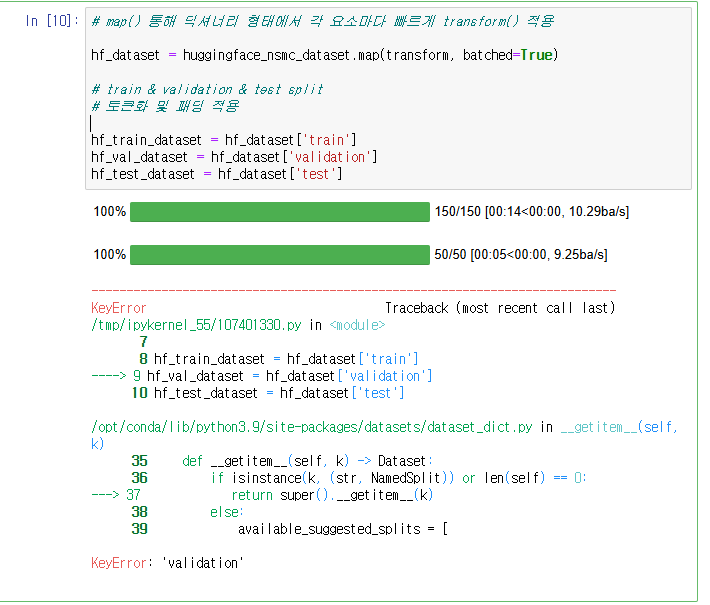

In [16]:
# map() 통해 딕셔너리 형태에서 각 요소마다 빠르게 transform() 적용 

# hf_dataset = huggingface_nsmc_dataset.map(transform, batched=True)
hf_dataset = sampled_dataset.map(transform, batched=True) # sampling data에 대해 다시 적용 

# train & validation & test split

hf_train_val = hf_dataset['train'].train_test_split(test_size=0.2) # train 데이터를 80%:20% 비율로 train과 validation으로 분할

hf_train_dataset = hf_train_val['train']   # train 데이터
hf_val_dataset = hf_train_val['test']      # validation 데이터
hf_test_dataset = hf_dataset['test']       # test 데이터

hf_train_dataset = hf_train_dataset.map(transform, batched=True) # 토큰화 및 패딩 적용  
hf_val_dataset = hf_val_dataset.map(transform, batched=True)
hf_test_dataset = hf_test_dataset.map(transform, batched=True)

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

## model training 

In [19]:
output_dir = os.getenv('HOME')+'/aiffel/transformers'

# TrainingArguments() : 학습 관련 설정을 미리 지정 

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로
    evaluation_strategy="epoch",       # evaluation하는 빈도
    learning_rate = 2e-5,              # learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,              # train 시킬 총 epochs
    weight_decay = 0.01,               # weight decay
)

In [20]:
# task에 따라 모델 출력 형식 고려하여 모델 성능 계산 방법 미리 지정 

metric = load_metric('accuracy')


def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

### [ERROR] RuntimeError: CUDA out of memory
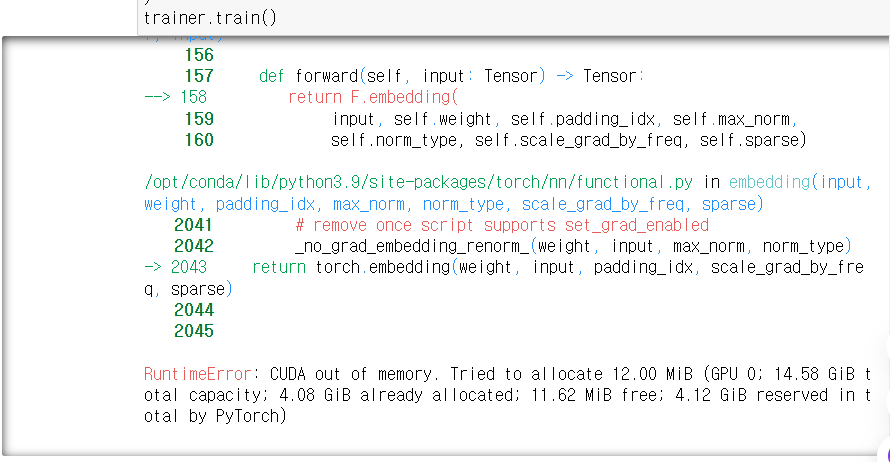
    
- 민혁님의 조언으로, 새로운 코드를 추가하여 에러 해결 시도함 

In [21]:
# 메모리 부족 문제 해결 위해 추가

import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [22]:
# 배치 사이즈 줄이기 

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로
    evaluation_strategy="epoch",       # evaluation하는 빈도
    learning_rate = 2e-5,              # learning_rate
    per_device_train_batch_size = 6,   # 각 device 당 batch size
    per_device_eval_batch_size = 6,    # evaluation 시에 batch size
    num_train_epochs = 3,              # train 시킬 총 epochs
    weight_decay = 0.01,               # weight decay
)

In [23]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 24000
  Num Epochs = 3
  Instantaneous batch size per device = 6
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 1
  Total optimization steps = 12000


Epoch,Training Loss,Validation Loss,Accuracy
1,0.390800,0.391358,0.881833
2,0.269000,0.513213,0.886000
3,0.158100,0.607168,0.888167


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-2000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoi

TrainOutput(global_step=12000, training_loss=0.2733720947901408, metrics={'train_runtime': 8265.381, 'train_samples_per_second': 8.711, 'train_steps_per_second': 1.452, 'total_flos': 1.894399598592e+16, 'train_loss': 0.2733720947901408, 'epoch': 3.0})

In [24]:
trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 6


{'eval_loss': 0.584000289440155,
 'eval_accuracy': 0.8879,
 'eval_runtime': 370.5527,
 'eval_samples_per_second': 26.987,
 'eval_steps_per_second': 4.499,
 'epoch': 3.0}

# STEP 4. Fine-tuning을 통하여 모델 성능(accuracy) 향상시키기
- 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.

### 데이터 전처리

In [ ]:
# map() 통해 딕셔너리 형태에서 각 요소마다 빠르게 transform() 적용 

# dataset 다시 불러오기 
hf_dataset = sampled_dataset.map(transform, batched=True) # sampling data

# train & validation & test split
hf_train_val = hf_dataset['train'].train_test_split(test_size=0.2) # train 데이터를 80%:20% 비율로 train과 validation으로 분할

hf_train_dataset = hf_train_val['train']   # train 데이터
hf_val_dataset = hf_train_val['test']      # validation 데이터
hf_test_dataset = hf_dataset['test']       # test 데이터

In [ ]:
# 결측값 확인 



In [ ]:
# 토큰화 및 패딩 적용

hf_train_dataset = hf_train_dataset.map(transform, batched=True)  
hf_val_dataset = hf_val_dataset.map(transform, batched=True)
hf_test_dataset = hf_test_dataset.map(transform, batched=True)

### TrainingArguments 조정 

In [ ]:
# TrainingArguments 조정 

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로
    evaluation_strategy="epoch",       # evaluation하는 빈도
    learning_rate = 2e-5,              # learning_rate
    per_device_train_batch_size = 6,   # 각 device 당 batch size
    per_device_eval_batch_size = 6,    # evaluation 시에 batch size
    num_train_epochs = 3,              # train 시킬 총 epochs
    weight_decay = 0.01,               # weight decay
)

In [ ]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

# STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교
- 아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.

    Data Collator

    Trainer.TrainingArguments 의 group_by_length

- STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

<회고>
- 데이터를 20%로 줄여서 진행하는데도 이렇게 학습 시간이 오래 걸리다니. 
- 허깅페이스를 가져다 쓰면 확실히 편하다는 것을 느꼈다.